In [2]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2023-01-09 12:57:04.285811: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a89e23f880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-09 12:57:04.285891: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-01-09 12:57:04.288380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-09 12:57:04.288471: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-01-09 12:57:04.288519: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-01-09 12:57:04.288549: I tensorflow/stream_executor/platform/default/dso_loader.cc:4

# Load Koch Meinhardt dataset


In [3]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [6]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

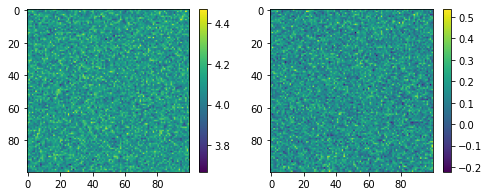

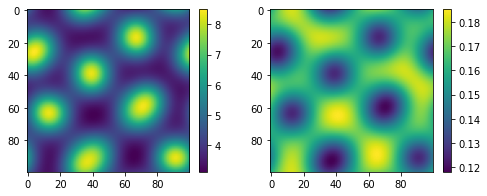

In [8]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

## Note: We use a prefactor to make the amplitude of u, v, u_xx, u_yy, u_t, v_xx, v_yy and v_t more or less in the same order of magnitude. And later, we do the inveres in solving the PDE. It is important for converging to the observed value.

In [9]:
# u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t
#outputs_correction_fact = [1, 1, .25, .25, 1000, 2.5, 2.5, 10000]
xx_factors = [1, 1]#[.25, 2.5]
yy_factors = [1, 1]#[.25, 2.5]
t_factors = [1, 1]#[1000, 10000]

dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[xx_factors[c] * dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[yy_factors[c] * dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
c_t = np.array([[t_factors[c] * (data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [10]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[xx_factors[c] * dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [11]:
T

513

In [12]:
c_t.shape

(2, 100, 100, 512)

In [13]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [14]:
T

2

In [15]:
data.shape

(2, 100, 100, 2)

In [16]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)

# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
#der_X = np.concatenate([obs_inputs, der_u_outputs[:,0:1], der_v_outputs[:,0:1]], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [17]:
der_X.shape

(32, 9)

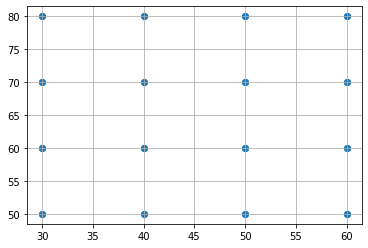

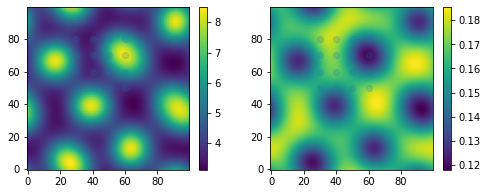

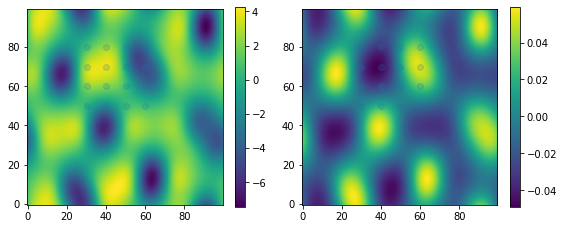

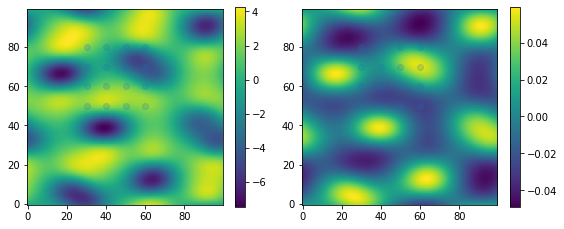

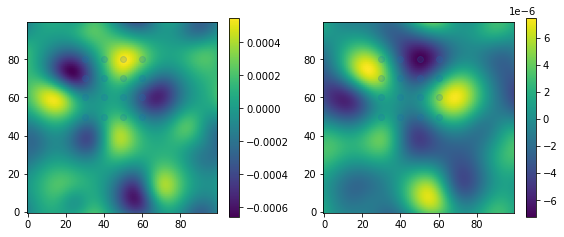

In [18]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

In [19]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
#ds_obs = TINN_Dataset(tf.float32, der_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, der_X, pde_X)

In [20]:
ds_obs.sizes

array([32, 32, 32])

In [509]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 128, 128, 2]
#layers = [3, 64,  2]

pinnKM = NN2(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard(
                    #dtype = pinnKM.dtype,
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    #D_u=PDE_Parameter("D_u", Parameter_Type.VARIABLE, 1.0, dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #D_v=PDE_Parameter("D_v", Parameter_Type.VARIABLE,  1.0, dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

    regularise=True
    )
obs_loss = Observation_Loss(layers=layers, 
                           residual_ret_names=("u", "v"),
                           )

der_loss = Derivatives_Loss(dtype = pinnKM.dtype,
                           #Ds = simulation.Ds,
                            regularise=True
                           )
modelKM = tu.TINN(pinnKM, 
                  losses= [obs_loss, der_loss, pde_resKM],
                  norm = L2(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [502]:
modelKM.loss_values

array([[0., 0.]])

In [515]:
#modelKM.optimizer.lr.assign(1e-4)
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 16,
                          dataset = ds_obs,
                          print_interval=100,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None)


Start of epoch 0
total loss: 2.495419621468, total regularised loss: 2.495419502258
Derivatives_Loss -> 
(1)  u_xx: 1.228431820869 (2)  v_xx: 0.019277983345 
Time taken: 15.50s

Start of epoch 100
total loss: 2.283339023590, total regularised loss: 2.283339023590
Derivatives_Loss -> 
(1)  u_xx: 1.128118038177 (2)  v_xx: 0.013551503420 
Time taken: 4.95s

Start of epoch 200
total loss: 2.282879471779, total regularised loss: 2.282879352570
Derivatives_Loss -> 
(1)  u_xx: 1.128022313118 (2)  v_xx: 0.013417429291 
Time taken: 4.82s

Start of epoch 300
total loss: 2.282799363136, total regularised loss: 2.282799243927
Derivatives_Loss -> 
(1)  u_xx: 1.127993345261 (2)  v_xx: 0.013406355865 
Time taken: 4.77s

Start of epoch 400
total loss: 2.282741069794, total regularised loss: 2.282741069794
Derivatives_Loss -> 
(1)  u_xx: 1.127972364426 (2)  v_xx: 0.013398165815 
Time taken: 4.78s

Start of epoch 500
total loss: 2.282696485519, total regularised loss: 2.282696485519
Derivatives_Loss ->

In [462]:
modelKM.optimizer.lr.assign(1e-4)
results_KM3 = modelKM.train(epochs = 3000+1,
                          batch_size = 16,
                          dataset = ds_obs,
                          print_interval=100,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None)


Start of epoch 0
total loss: 2.255810260773, total regularised loss: 2.255810260773
Derivatives_Loss -> 
(1)  u_xx: 1.127905130386 
Time taken: 0.06s

Start of epoch 100
total loss: 2.255810141563, total regularised loss: 2.255810260773
Derivatives_Loss -> 
(1)  u_xx: 1.127905070782 
Time taken: 2.01s

Start of epoch 200
total loss: 2.255810022354, total regularised loss: 2.255810022354
Derivatives_Loss -> 
(1)  u_xx: 1.127905011177 
Time taken: 2.00s

Start of epoch 300
total loss: 2.255809903145, total regularised loss: 2.255809783936
Derivatives_Loss -> 
(1)  u_xx: 1.127904951572 
Time taken: 2.01s

Start of epoch 400
total loss: 2.255810022354, total regularised loss: 2.255810022354
Derivatives_Loss -> 
(1)  u_xx: 1.127905011177 
Time taken: 1.99s

Start of epoch 500
total loss: 2.255809903145, total regularised loss: 2.255809783936
Derivatives_Loss -> 
(1)  u_xx: 1.127904951572 
Time taken: 1.93s

Start of epoch 600
total loss: 2.255809903145, total regularised loss: 2.2558097839

KeyboardInterrupt: 

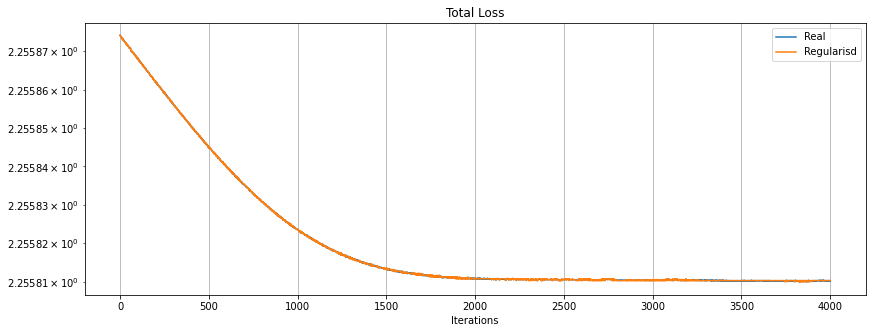

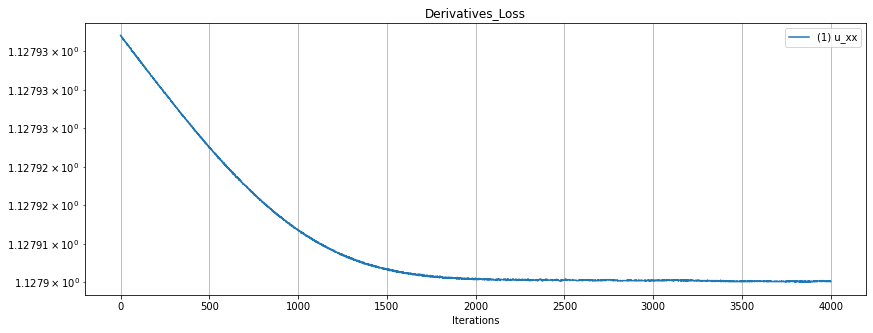

In [461]:
plot_result(merge_dict( results_KM, results_KM2), 
           modelKM, start=2000 ,skip=1)

In [254]:
test_d = obs_X[:,:3].astype(np.float32)

In [471]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[0.99765575, 0.97197604]
[0.99765575 0.9719761 ]
[0.99882716 0.9858885 ]


In [472]:
@tf.function
def derivatives(pinn, x):
    return pde_resKM.derivatives(pinn, x)

In [516]:
(y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy) =  derivatives(pinnKM,test_d)


u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [517]:
der_u_outputs.shape

(32, 3)

In [518]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

1.0619403772790543
1.1434144606369063
3.785262193589142
0.11565186497461358
0.22829934306825111
2.4887166922759025


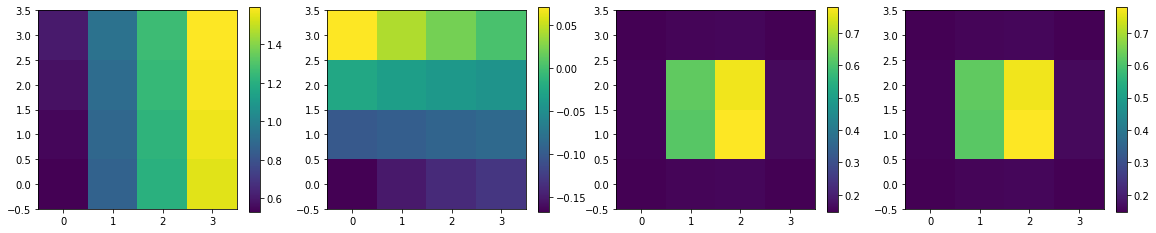

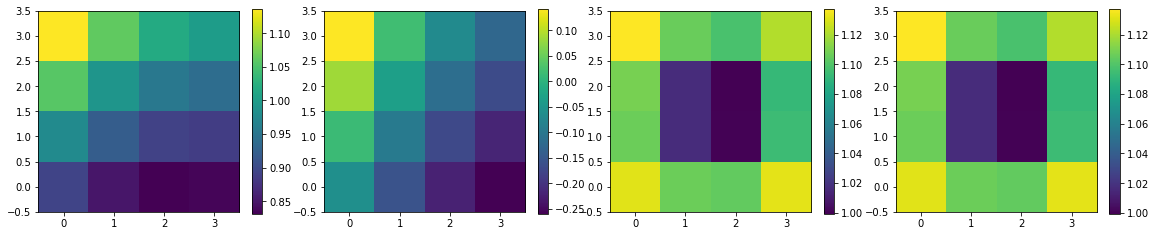

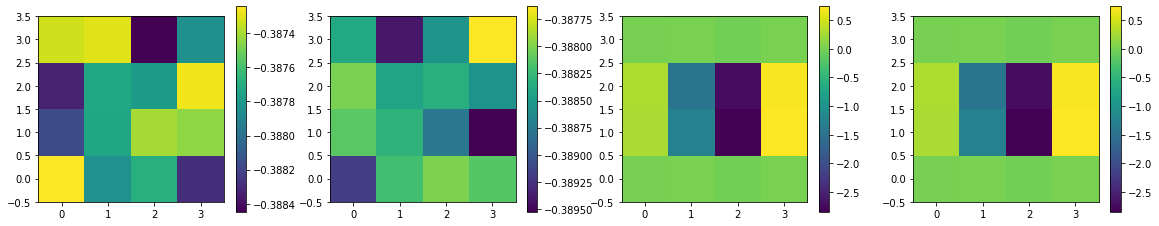

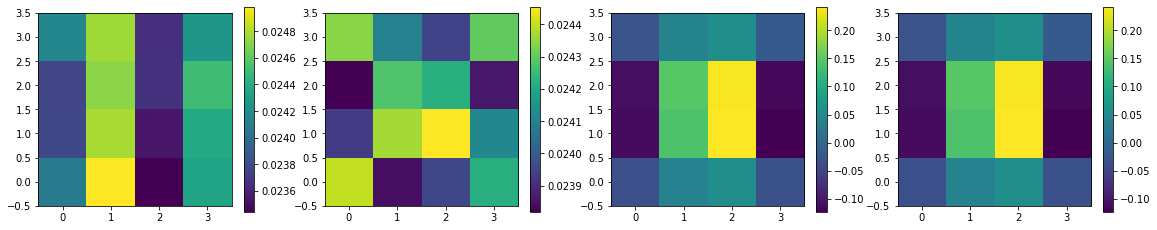

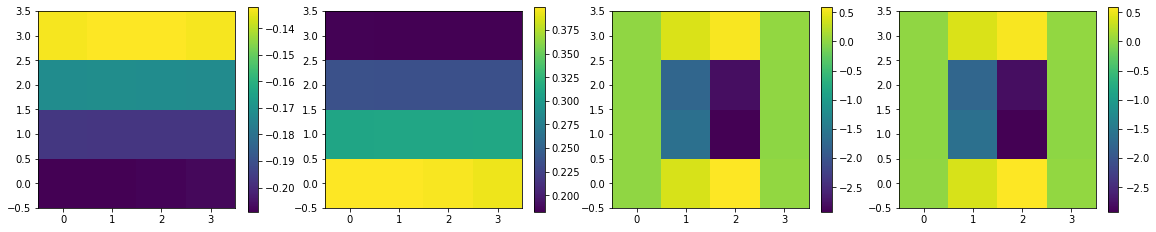

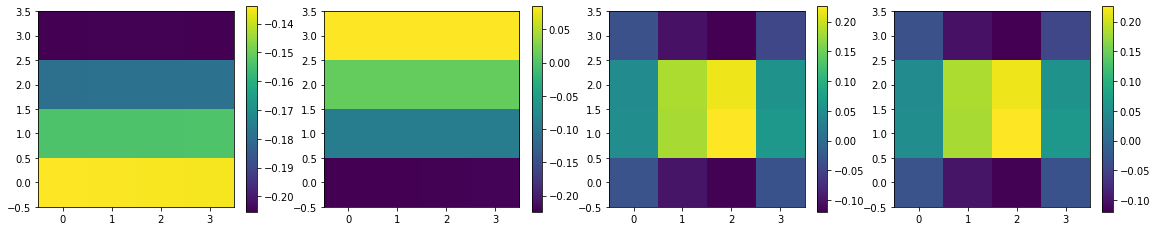

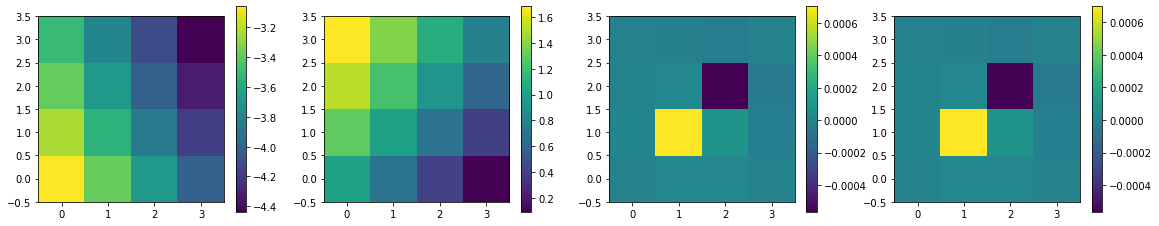

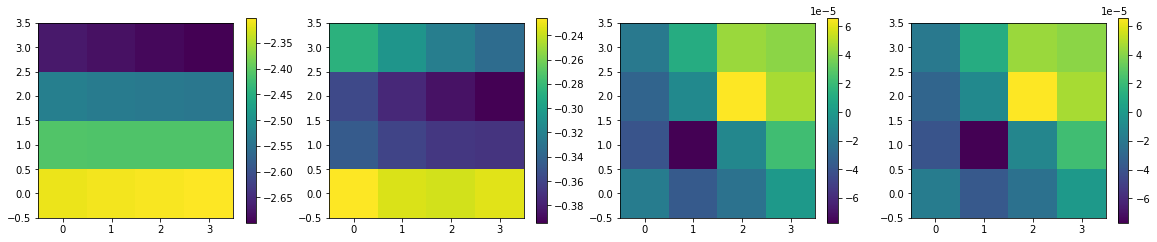

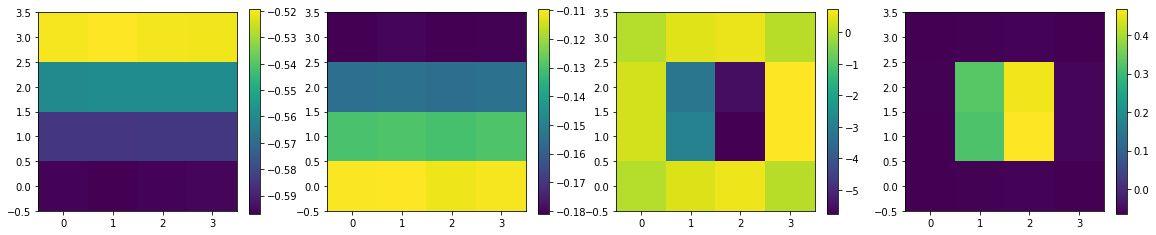

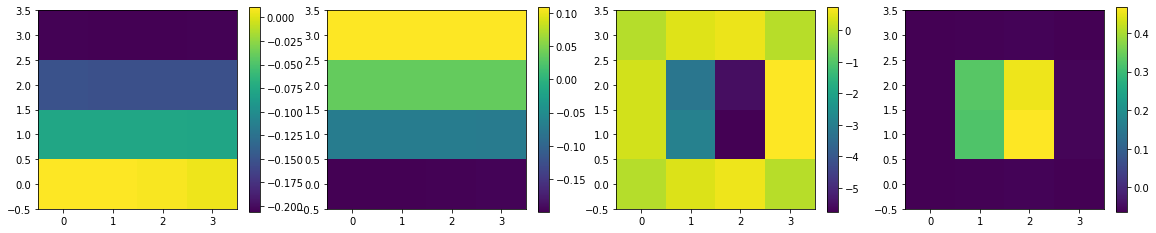

In [519]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1])
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2])
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2])

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])

In [43]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [338]:
params = np.array([rho_u, D, rho_v])

In [354]:
params2 = np.array([pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.D.get_value(0).numpy()[0], 
                    pde_resKM.rho_v.get_value(0).numpy()[0]])

In [355]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = (u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_sol = np.vstack((np.c_[f_sol,  [0]*n2,  [0]*n2],
                   np.c_[[0]*n2,  vxxyy_sol, -f_sol]))


u_dt_sol = (u_t.numpy()/100).flatten()
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = np.r_[(uxxyy_sol-u_dt_sol-u_sol+1, -v_dt_sol+1)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [356]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

0.012888034596179841

In [357]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

8.206002896477086e-05

In [358]:
params3 = linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))
params3

array([1.95058623e-02, 9.77675650e+01, 1.47502555e-02])

In [359]:
np.sqrt(np.mean(((np.dot(A_sol, params3)+b_sol))**2))

4.9839658476115134e-05

In [360]:
params2

array([1.9505853e-02, 9.7756248e+01, 1.4748963e-02], dtype=float32)

In [279]:
kappa_u

0.010000000000000002

In [82]:
np.max(u_actual)-np.min(u_actual)

6.341826562258701

In [208]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [248]:
np.sqrt(0.00097)/np.sqrt(np.max(der_v_outputs[:test_size, 0]**2 ))

0.12872605200828996

In [249]:
np.sqrt(0.00097)/np.sqrt(np.mean(der_v_outputs[:test_size, 0]**2 ))

0.2637518238175379

In [241]:
np.max(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) - np.min(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) 

0.5324497151440455

In [282]:
test_size = 32
u_actual = u.numpy().flatten()
v_actual = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (u_xx.numpy() + u_yy.numpy()).flatten()

#(v_xx.numpy() + v_yy.numpy()).flatten()/10
vxxyy_actual = (der_v_outputs[:test_size, 0] + #np.random.normal(0, .05, test_size)+
                der_v_outputs[:test_size, 1]).flatten()/10
vxxyy_actual = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (u_t.numpy()/100).flatten()
v_dt_actual = (v_t.numpy()/1000).flatten()

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [283]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.96889015e-02, 6.07703016e+01, 1.06397409e-02])

In [172]:
test_size = 32
u_actual = obs_outputs[:test_size, 0]
v_actual = obs_outputs[:test_size, 1]

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])
vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (der_u_outputs[:test_size, 2] /100)
v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [173]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.97328100e-02, 9.94934181e+01, 1.51207473e-02])

In [284]:
def add_noise(noise_level = 0, kappa_sol = None):
    test_size = 33
    u_actual = obs_outputs[:test_size, 0].copy() 
    v_actual = obs_outputs[:test_size, 1].copy()    
    test_size = len(u_actual)
    
    if kappa_sol is None:
        kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

    f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


    uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])    
    
    
    if noise_level > 0:
        v_xx_band = np.max(der_v_outputs[:test_size, 0])-np.min(der_v_outputs[:test_size, 0])
        v_yy_band = np.max(der_v_outputs[:test_size, 1])-np.min(der_v_outputs[:test_size, 1])
        vxx_actual = der_v_outputs[:test_size, 0] + np.random.normal(0, v_xx_band*noise_level , test_size)
        vyy_actual = der_v_outputs[:test_size, 1] + np.random.normal(0, v_yy_band*noise_level , test_size)
        vxxyy_actual =(vxx_actual + vyy_actual).flatten()/10        
    else:
        vxx_actual = der_v_outputs[:test_size, 0]
        vyy_actual = der_v_outputs[:test_size, 1]
        vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

    A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                          np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


    u_dt_actual = (der_u_outputs[:test_size, 2] /100)
    v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

    b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]
    params_pred = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
    
    v_xx_err = np.mean((der_v_outputs[:test_size, 0] - vxx_actual)**2)
    v_yy_err = np.mean((der_v_outputs[:test_size, 1] - vyy_actual)**2)    
    return tuple(params_pred.tolist() )+ (v_xx_err, v_yy_err)
    

In [201]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [285]:
noise_levels = np.linspace(0,.3, 100)
ensumble_n = 100
for n in range(ensumble_n):
    if n == 0:
        estimates = np.array([add_noise(n_l) for n_l in noise_levels])
    else:
        estimates += np.array([add_noise(n_l) for n_l in noise_levels])
        
estimates /= ensumble_n

In [286]:
estimates.shape

(100, 5)

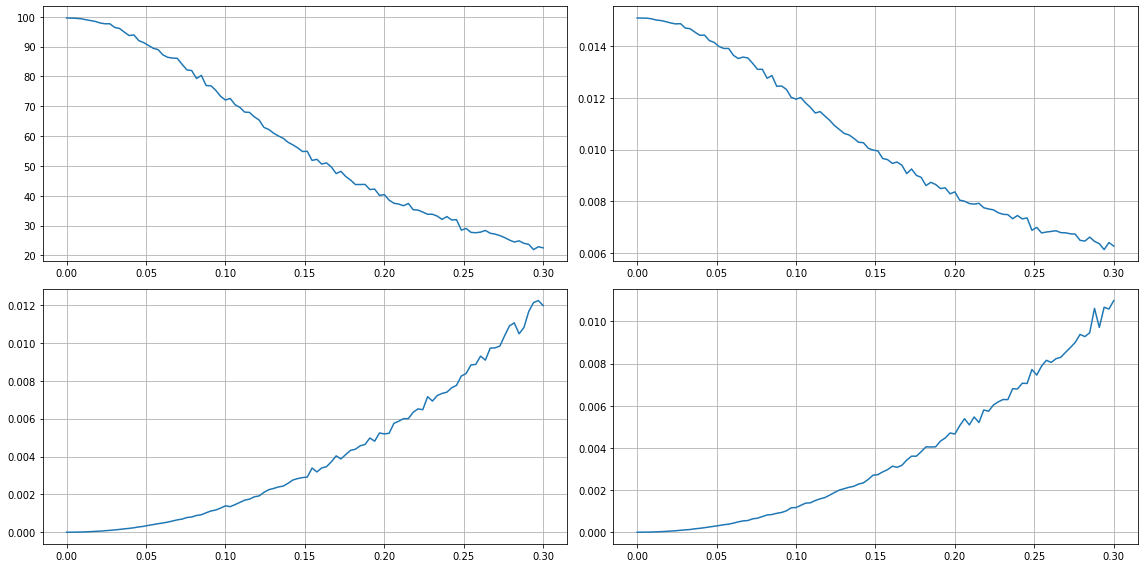

In [287]:
_ = plt.figure(figsize=(16, 8))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i*2+j+1)
        plt.plot(noise_levels, estimates[:, i*2+j+1])        
        plt.grid()
plt.tight_layout()
plt.show()

In [138]:
add_noise(0)

(0.01973280997722836,
 99.49341812882234,
 0.015120747280319324,
 0.0,
 0.0,
 3.7494859510203646e-06,
 8.287541347416645e-07)

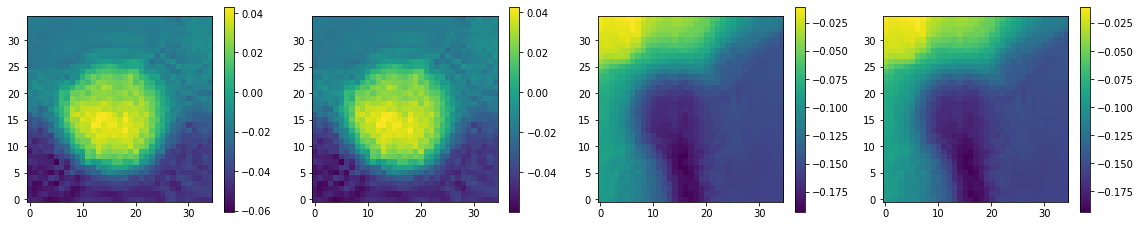

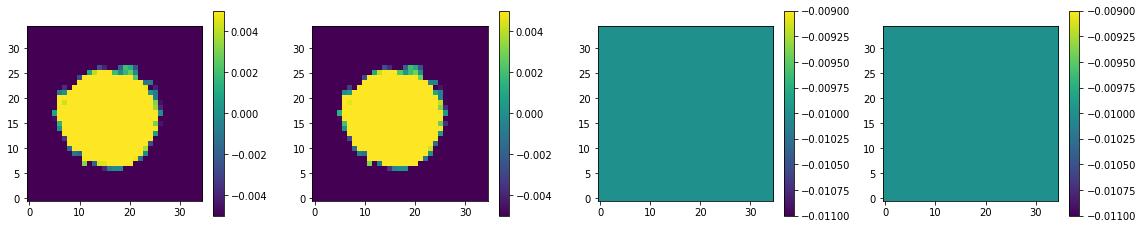

In [56]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

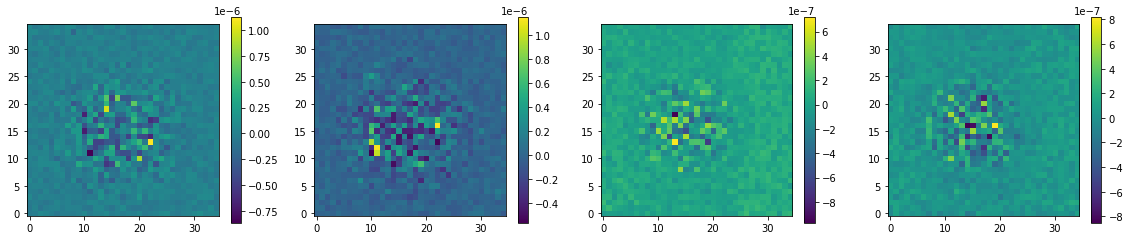

In [57]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)

In [61]:
res_obs = lsq_linear(A_sol, b_sol, bounds=(0.0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1, -1, -1])
        cost: 16551.379752990466
         fun: array([ 0.55743337,  0.55322146,  0.55879426, ..., -0.99963897,
       -0.99963588, -0.99964142])
     message: 'The first-order optimality measure is less than `tol`.'
         nit: 13
  optimality: 4.320909614557874e-28
      status: 1
     success: True
           x: array([1.27266364e-46, 2.09048140e-28, 8.46731860e-48])

In [269]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size
u_obs = obs_outputs[:,0].flatten()
v_obs = obs_outputs[:,1].flatten()
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n2, [0]*n2, [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2, -f_obs, [1]*n2]))

uxxyy_obs =simulation.Ds[0] *  (der_u_outputs[:,0] + der_u_outputs[:,1]).flatten()
vxxyy_obs =simulation.Ds[1] *  (der_v_outputs[:,0] + der_v_outputs[:,1]).flatten()
u_dt = der_u_outputs[:,2].flatten()
v_dt = der_v_outputs[:,2].flatten()

b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]

In [169]:
np.sqrt(np.mean(((np.dot(A_obs, params)+b_obs))**2))

4.3139633449820096e-07

In [303]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1,  0])
        cost: 55.98322605362867
         fun: array([0.01198398, 0.01190489, 0.01179273, ..., 0.13051092, 0.13049243,
       0.1304939 ])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.7763568394002505e-14
      status: 2
     success: True
           x: array([2.11852294e-033, 7.28018337e-002, 2.27743983e-002, 4.94065646e-324,
       6.59956339e-002])

In [136]:
b_obs = np.r_[(uxxyy_obs, vxxyy_obs)]

In [160]:
res1=(np.dot(A_obs, params2)+b_obs
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_obs, params2)+b_obs
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_obs, params2)+b_obs
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_obs, params2)+b_obs
     )[3*block_size:].reshape(block_x, block_y).T

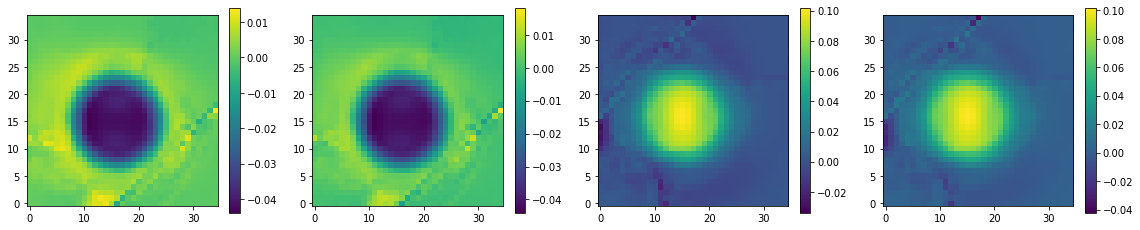

In [161]:
p(res1,res2,res3,res4)

In [380]:
import rdsolver

In [403]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 2*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_resKM.sigma_u.get_value(0).numpy()[0]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_resKM.sigma_v.get_value(0).numpy()[0]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_resKM.mu_u.get_value(0).numpy()[0]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_resKM.rho_u.get_value(0).numpy()[0],
          pde_resKM.rho_v.get_value(0).numpy()[0],
          pde_resKM.kappa_u.get_value(0).numpy()[0])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


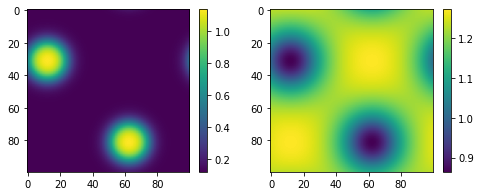

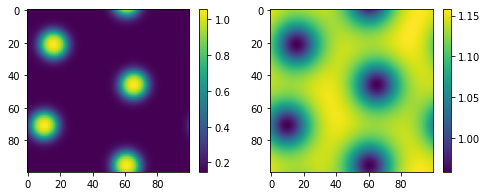

In [406]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [388]:
simulation

Simulation(name='Koch_Meinhardt_9', n=(100, 100), L=(8, 8), Ds=(0.01, 1.0), dt=0.001, t_start=0, t_end=768.0, t_steps=769, dt_arr=None, parameters={'kappa_u': 1.0, 'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'sigma_u': 0.1, 'sigma_v': 0.1}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, tol=0.001, sample_parameters=True, sample_parameters_num=10, sample_parameters_std=(0.0, 0.01, 0.01, 0.01, 0.001, 0.001), same_init=True, c0=None)

In [421]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 4*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = 4*simulation.parameters["sigma_u"]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = simulation.parameters["sigma_v"]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -4*simulation.parameters["mu_u"]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (4*simulation.parameters["rho_u"],
          simulation.parameters["rho_v"],
          simulation.parameters["kappa_u"])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [02:05<00:00, 12.55s/it]


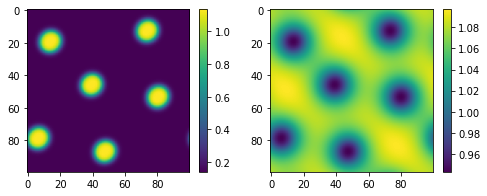

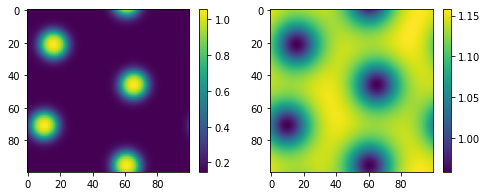

In [422]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [407]:
print(pde_resKM.trainables_str())

sigma_u: 0.03358 sigma_v: 0.08917 mu_u: 0.38960 rho_u: 0.74692 
rho_v: 1.29434 kappa_u: 0.75477 


In [408]:
simulation.parameters

{'kappa_u': 1.0,
 'mu_u': 1.0,
 'rho_u': 1.95,
 'rho_v': 1.5,
 'sigma_u': 0.1,
 'sigma_v': 0.1}

In [412]:
(1/0.38960)#*0.03358

2.566735112936345

In [414]:
2.5*0.74692 

1.8673000000000002

In [268]:
minimize_parameters(pde_resKM, pinnKM, test_d, [pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.kappa_u], 
                    method="Nelder-Mead", tol=1e-9 )

 final_simplex: (array([[0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ]]), array([4.10391617, 4.10391617, 4.10391617, 4.10391617]))
           fun: 4.103916168212891
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 119
        status: 0
       success: True
             x: array([0.02013884, 0.06914701, 0.0114    ])

In [62]:
import copy

In [81]:

pde_resKM2 = copy.deepcopy(pde_resKM) 

In [82]:

@tf.function
def resi4(v1, v2):
    pde_resKM2.D.set_value(v1)
    pde_resKM2.rho_v.set_value(v2)
    return pde_resKM2.residual(pinnKM, test_d)   

In [156]:
D_range = np.linspace(40, 80, 30)
rho_v_range = np.linspace(.01, .012, 30)

D_mesh, rho_v_mesh = np.meshgrid(D_range, rho_v_range)

In [157]:
v_res = np.zeros_like(rho_v_mesh)
l2_norm = L2()
for i, _ in enumerate(D_mesh):    
    
    for j, _ in enumerate(rho_v_mesh):
        v1 = D_mesh[i,j]
        v2 = rho_v_mesh[i,j]        
        
        test_pde_u, test_pde_v = resi4(v1.astype(np.float32), v2.astype(np.float32))        
        
        v_res[i,j] = l2_norm.reduce_norm((test_pde_v,)).numpy()[0]
        

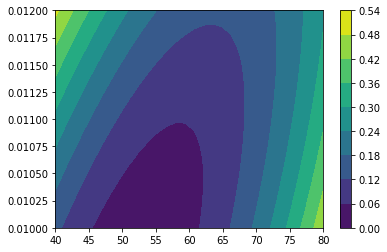

In [159]:
#_ = plt.figure(figsize=(16,4))

plt.contourf(D_range, rho_v_range, v_res)
#plt.imshow(v_res)
plt.colorbar()

plt.show()


In [160]:
print(pde_resKM.trainables_str())

D: 52.67937 rho_u: 0.02041 rho_v: 0.00995 kappa_u: 0.01109 



In [161]:
pde_resKM.outputs_correction_fact

ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.001>])

In [167]:
@tf.function
def resi2():
    outputs = pinnKM.net(test_d)
    u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (
        outputs[:, 0] * pde_resKM.outputs_correction_fact[0],
        outputs[:, 1] * pde_resKM.outputs_correction_fact[1],
        outputs[:, 2] * pde_resKM.outputs_correction_fact[2],
        outputs[:, 3] * pde_resKM.outputs_correction_fact[3],
        outputs[:, 4] * pde_resKM.outputs_correction_fact[4],
        outputs[:, 5] * pde_resKM.outputs_correction_fact[5],
        outputs[:, 6] * pde_resKM.outputs_correction_fact[6],
        outputs[:, 7] * pde_resKM.outputs_correction_fact[7],
    )
    D = pde_resKM.D.get_value(0)        
    rho_v = pde_resKM.rho_v.get_value(0)
    kappa_u = pde_resKM.kappa_u.get_value(0)
    f = u * u * v / (1.0 + kappa_u * u * u)
    return (v_t - 1, v_xx + v_yy, f)

In [168]:
kappa_u

0.010000000000000002

In [169]:

#pde_resKM.kappa_u.set_value(0.01136 )
pde_resKM.kappa_u.set_value(kappa_u)
a, d, b = resi2()

In [165]:

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol =  f_sol

vxxyy_sol = D * (v_xx.numpy() + v_yy.numpy()).flatten()/10
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = v_dt_sol-vxxyy_sol-1

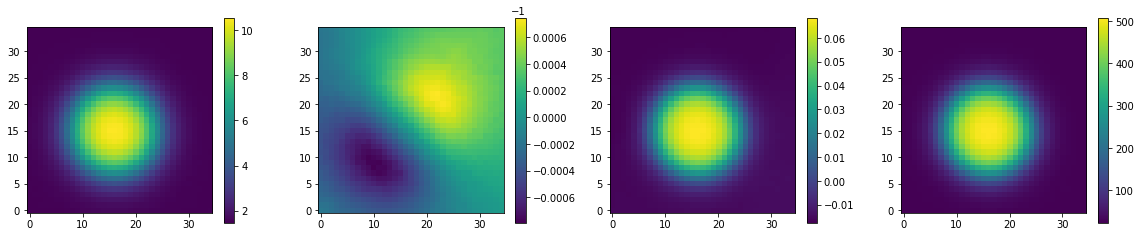

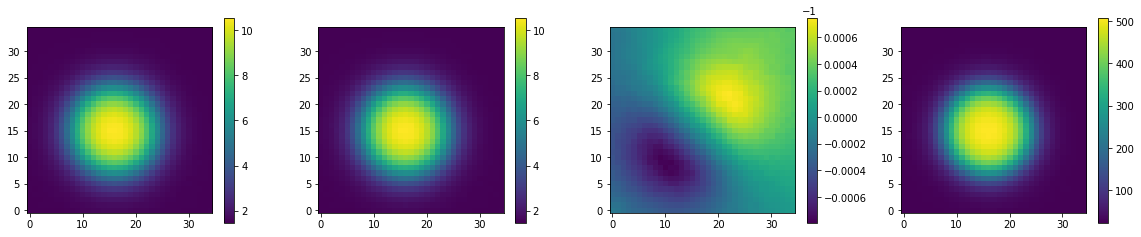

In [171]:
p(u1,  a.numpy()[:block_size].reshape(block_x, block_y).T,d.numpy()[:block_size], b.numpy()[:block_size])
p(u1, u2, a.numpy()[block_size:], b.numpy()[block_size:])
#p(u1, u2, a.numpy()[:block_size]/b.numpy()[:block_size], a.numpy()[block_size:]/b.numpy()[block_size:])
#p(u1, u2, b_sol[block_size:], A_sol[block_size:] )

In [102]:
A_sol[2*block_size:, 1].shape

(2450,)

In [104]:
b_sol[2*block_size:].shape

(2450,)